# Experiment 1: VUS vs FF-VUS vs FF-VUS-GPU vs AUC at slope 0

## Setup

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import importlib

from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

project_root_path = os.path.join('..', '..')
experiment_path = os.path.join(project_root_path, 'experiments', 'vus_ffvus_auc_0_tsb')
results_path = os.path.join(experiment_path, 'results')

save_fig_path = os.path.join(experiment_path, 'figures')
os.makedirs(save_fig_path, exist_ok=True)

%load_ext autoreload
%autoreload 2
import SylliGraph
importlib.reload(SylliGraph)
sgraph = SylliGraph.SylliGraph(experiment_path)

In [17]:
result_files = [file for file in os.listdir(results_path) if file.endswith('.csv')]
print(f'Number of result files: {len(result_files)}')

df = pd.DataFrame()

# Read and combine all files
for file in tqdm(result_files):
    file_path = os.path.join(results_path, file)
    curr_df = pd.read_csv(file_path)
    df = pd.concat([df, curr_df], ignore_index=True)

df.sample(3)

Number of result files: 4


  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 116.07it/s]


,Time series,Length,Number of anomalies,Anomalies average length,Slope size,Step,Global mask,Slopes,Existence,Confusion matrix,...,Score mask time,Position time,Slopes time,Existence time,Confusion matrix time,Precision recall curve time,Integral time,Metric,Metric value,Metric time
7046,GHL/38_Lev_corr_Temp_fault_seed_166_vars_23.te...,200000,1,863.0,0.0,NaN,NaN,NaN,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VUS,0.004890,0.077336
7058,GHL/03_Lev_fault_Temp_corr_seed_19_vars_23.tes...,200000,1,145.0,0.0,NaN,NaN,NaN,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VUS,0.010409,0.072469
6033,OPPORTUNITY/S1-ADL4.test.csv@16.out,32660,2,500.0,0.0,NaN,NaN,NaN,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VUS,0.193706,0.010852


In [18]:
color_palette = {
    'FF-VUS': 'lightgreen',
    'FF-VUS-GPU': 'lightblue',
    'AUC': 'lightcoral',
    'VUS': 'orange',
}

## Analysis

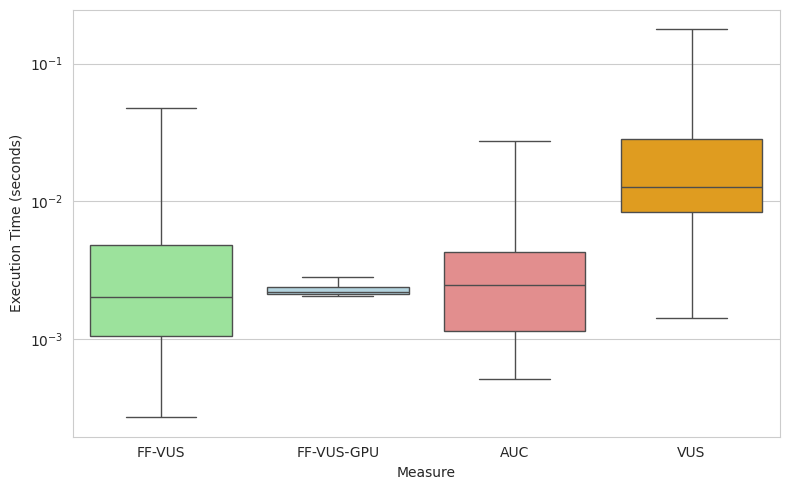

In [19]:
# TODO: Remove -PR
# TODO: Add (L: 0, E: False)

# What is the execution time difference
median_times = df.groupby('Metric')['Metric time'].median()
order = median_times.sort_values().index.to_list()

plt.figure(figsize=(8, 5))
sns.boxplot(y='Metric time', x='Metric', hue='Metric', data=df, showfliers=False, log_scale=True, palette=color_palette, order=order)
plt.xlabel('Measure')
plt.ylabel('Execution Time (seconds)')
plt.tight_layout()
plt.savefig(os.path.join(save_fig_path, 'exec_time_comparison.svg'))
plt.show()

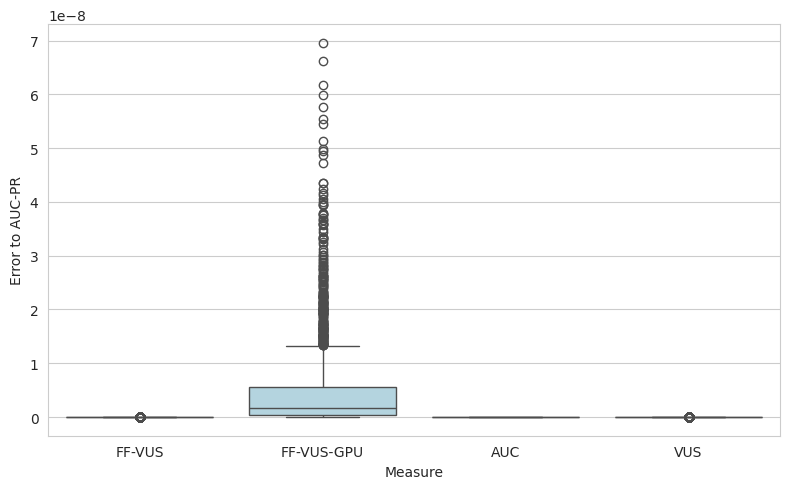

In [25]:
# TODO: We will show this in the next subsection, where we compare FFVUS, VUS for every slope

# What is the error between the difference metrics
plt.figure(figsize=(8, 5))
metrics = df['Metric'].unique()

values_df = df[['Time series', 'Metric', 'Metric value']]
values_df = values_df.pivot(columns='Metric', index='Time series', values='Metric value')
dif_df = values_df.copy()
for metric in metrics: 
    dif_df[metric] = values_df[metric] - values_df['AUC']
dif_df

sns.boxplot(dif_df.abs(), showfliers=True, palette=color_palette, order=order, log_scale=False)
plt.xlabel('Measure')
plt.ylabel('Error to AUC-PR')
plt.tight_layout()
plt.savefig(os.path.join(save_fig_path, 'error_to_aucpr.svg'))
plt.show()

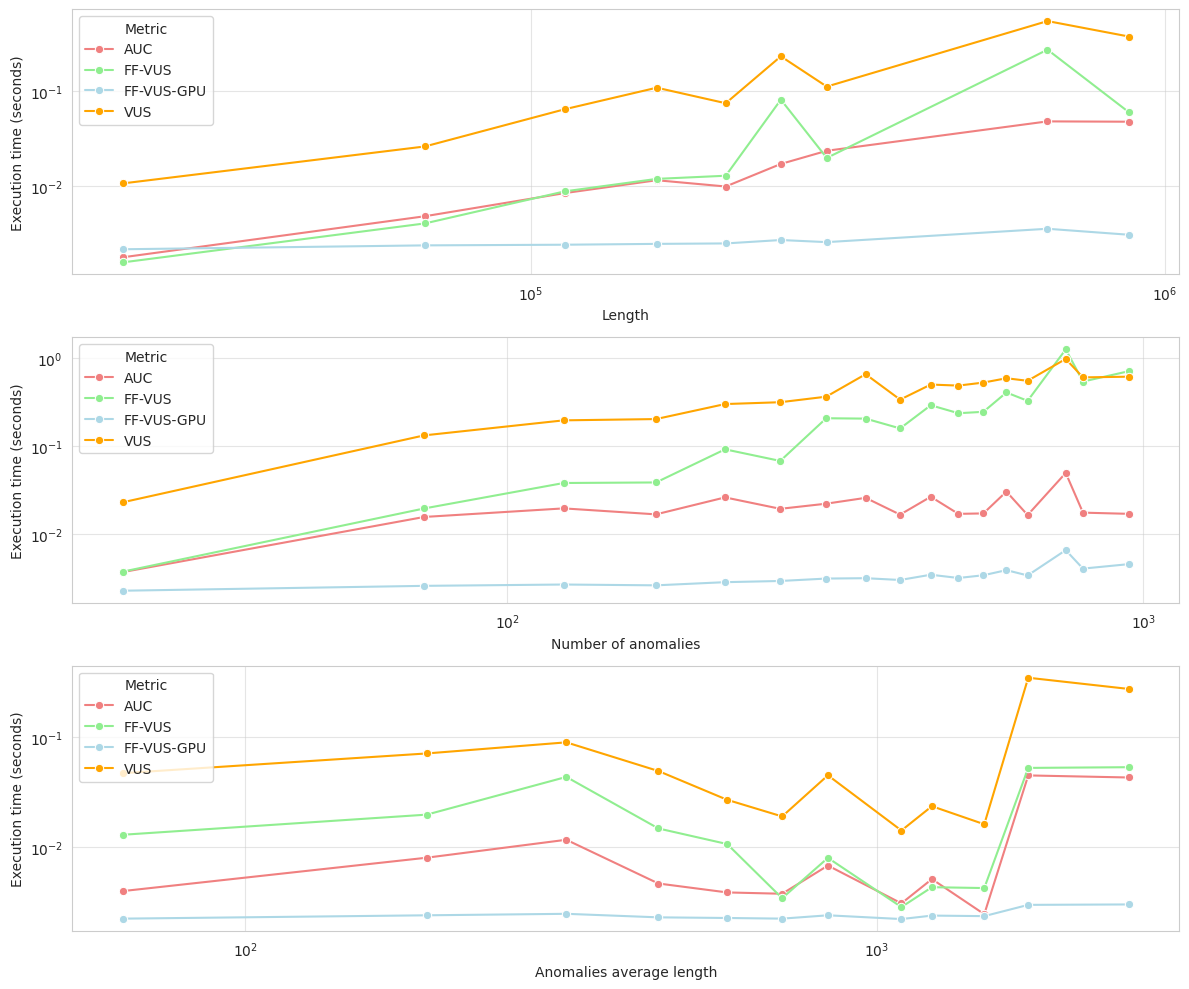

In [26]:
fig, ax = plt.subplots(3, 1, figsize=(12, 10))
attributes = ["Length", "Number of anomalies", "Anomalies average length"]
bins = 20  # adjust based on data spread
curr_df = df.copy()

for attribute, axis in zip(attributes, ax):
    # Bin the attribute
    # curr_df[f'{attribute}_bin'] = pd.qcut(curr_df[attribute], q=bins, duplicates='drop')
    curr_df[f'{attribute}_bin'] = pd.cut(curr_df[attribute], bins=bins)
    
    # Group by bin and metric, compute mean
    grouped = (
        curr_df
        .groupby([f'{attribute}_bin', 'Metric'], observed=False)['Metric time']
        .mean()
        .reset_index()
    )

    # Convert bin to the midpoint for plotting
    grouped['bin_center'] = grouped[f'{attribute}_bin'].apply(lambda x: x.mid)

    # Plot
    sns.lineplot(
        x='bin_center',
        y='Metric time',
        hue='Metric',
        data=grouped,
        ax=axis,
        palette=color_palette,
        marker='o'
    )

    # axis.set_title(f"Metric Time vs {attribute}")
    axis.set_xlabel(attribute)
    axis.set_ylabel("Execution time (seconds)")
    axis.set_yscale('log')
    axis.set_xscale('log')
    axis.grid(axis='both', alpha=0.5)

plt.tight_layout()
plt.savefig(os.path.join(save_fig_path, 'exec_time_per_attr.svg'))
plt.show()